<a href="https://colab.research.google.com/github/EconomiaUNMSM/Prueba/blob/main/modelo_tesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#%% Modelo 1: PBI y Deuda P√∫blica con machine Learning
import time
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, coint
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import kpss
from sklearn.model_selection import train_test_split
from warnings import filterwarnings
filterwarnings("ignore")

# Extraer archivos
# PBI Trimestral 2000 - 2024
pbi = pd.read_csv(r'/CSV/Trimestrales-20250505-161109.csv')

# Gastos de capital Trimestral 2006 - 2024
gc = pd.read_csv(r'/CSV/Trimestrales-20250505-161617.csv')

# Deuda P√∫blica Externa Trimestral 1999 - 2024
dpe = pd.read_csv(r'/CSV/Trimestrales-20250505-161753.csv', encoding='latin-1')

# Deuda P√∫blica Interna Trimestral 1999 - 2024
dpi = pd.read_csv(r'/CSV/Trimestrales-20250505-162125.csv', encoding='latin-1')

# Indice de Precios al Consumidor Mensual 1999 - 2024
ipc = pd.read_csv(r'/CSV/Mensuales-20250505-162435.csv', encoding='latin-1')

# Tipo de Cambio Interbancario - Promedio Mensual 1999 - 2024
tc = pd.read_csv(r'/CSV/Mensuales-20250505-162601.csv')

In [3]:
# TRATAMIENTO DE LOS DATOS

# TASA DE INFLACI√ìN TRIMESTRAL
# Mismos intervalos de tiempo
# Indice de Precios al Consumidor Trim 1999 - 2024
# --- 1) Limpieza y conversi√≥n de tipos ---
ipc = ipc.iloc[1:].copy()
ipc.columns = ['Mes', 'IPC']
ipc['IPC'] = pd.to_numeric(ipc['IPC'], errors='coerce')

# --- 2) Mapeo de abreviaturas espa√±olas a n√∫mero de mes ---
mes_map = {
    'Ene': 1, 'Feb': 2, 'Mar': 3, 'Abr': 4,
    'May': 5, 'Jun': 6, 'Jul': 7, 'Ago': 8,
    'Sep': 9, 'Set': 9,  # en Per√∫ a veces aparece "Set"
    'Oct':10, 'Nov':11, 'Dic':12
}

# extraigo la parte de texto (mes) y la parte num√©rica (a√±o)
ipc['mes_str']  = ipc['Mes'].str.extract(r'([A-Za-z]+)')
ipc['anio_2d'] = ipc['Mes'].str.extract(r'(\d{2})').astype(int)

# convierto a num√©rico
ipc['month'] = ipc['mes_str'].map(mes_map)
# tomo a√±os ‚Äô70‚Äì‚Äô99 ‚Üí 1970‚Äì1999, y ‚Äô00‚Äì‚Äô69 ‚Üí 2000‚Äì2069
ipc['year']  = ipc['anio_2d'].apply(lambda x: 1900 + x if x >= 70 else 2000 + x)

# --- 3) Armo la fecha y la pongo de √≠ndice ---
ipc['Fecha'] = pd.to_datetime(dict(year=ipc['year'], month=ipc['month'], day=1))
ipc = ipc.set_index('Fecha')

# --- 4) Inflaci√≥n trimestral (%) ---
ipc['Inflaci√≥n_Trimestral'] = ipc['IPC'].pct_change(periods=3) * 100

# --- 5) Resultado final ---
resultado = ipc[['IPC', 'Inflaci√≥n_Trimestral']].dropna()
print(resultado.head(8))

# Solo los datos trimestrales
# Filtra solo los meses 3 (Mar), 6 (Jun), 9 (Set), 12 (Dic)
ipc_trimestral = ipc[ipc.index.month.isin([3, 6, 9, 12])]

# Solo mostramos las columnas de inter√©s
ipc_trimestral =  ipc_trimestral[['Inflaci√≥n_Trimestral']].dropna()

########################################################################
# Tipo de Cambio Trimestral
# --- 1) Limpieza y conversi√≥n de tipos ---
tc = tc.iloc[1:].copy()
tc.columns = ['Mes', 'TC']
tc['TC'] = pd.to_numeric(tc['TC'], errors='coerce')

# --- 2) Mapeo de abreviaturas espa√±olas a n√∫mero de mes ---
mes_map = {
    'Ene': 1, 'Feb': 2, 'Mar': 3, 'Abr': 4,
    'May': 5, 'Jun': 6, 'Jul': 7, 'Ago': 8,
    'Sep': 9, 'Set': 9,  # en Per√∫ a veces aparece "Set"
    'Oct':10, 'Nov':11, 'Dic':12
}

# extraigo la parte de texto (mes) y la parte num√©rica (a√±o)
tc['mes_str']  = tc['Mes'].str.extract(r'([A-Za-z]+)')
tc['anio_2d'] = tc['Mes'].str.extract(r'(\d{2})').astype(int)

# convierto a num√©rico
tc['month'] = tc['mes_str'].map(mes_map)
# tomo a√±os ‚Äô70‚Äì‚Äô99 ‚Üí 1970‚Äì1999, y ‚Äô00‚Äì‚Äô69 ‚Üí 2000‚Äì2069
tc['year']  = tc['anio_2d'].apply(lambda x: 1900 + x if x >= 70 else 2000 + x)

# --- 3) Armo la fecha y la pongo de √≠ndice ---
tc['Fecha'] = pd.to_datetime(dict(year=tc['year'], month=tc['month'], day=1))
tc = tc.set_index('Fecha')

# --- 4) Tipo de Cambio trimestral (%) ---
tc['Tipo_Cambio_Trimestral'] = tc['TC'].pct_change(periods=3) * 100

# --- 5) Resultado final ---
resultado = tc[['TC', 'Tipo_Cambio_Trimestral']].dropna()
print(resultado.head(8))

# Solo los datos trimestrales
# Filtra solo los meses 3 (Mar), 6 (Jun), 9 (Set), 12 (Dic)
tc_trimestral = tc[tc.index.month.isin([3, 6, 9, 12])]

# Solo mostramos las columnas de inter√©s
tc_trimestral =  tc_trimestral[['Tipo_Cambio_Trimestral']].dropna()

########################################################################
# Combinar las series
# Tratar PBI
pbi = pd.DataFrame(pbi.iloc[1:101]["PN02538AQ"])
pbi = pbi.rename(columns={"PN02538AQ": "PBI_trimestral"})
pbi.index = tc_trimestral.index

# Tratar Deuda Externa
dpe = pd.DataFrame(dpe.iloc[5:105]["PN03372FQ"])
dpe = dpe.rename(columns={"PN03372FQ": "DPE_trimestral"})
dpe.index = tc_trimestral.index

# Tratar Deuda Interna
dpi = pd.DataFrame(dpi.iloc[5:105]["PN03381FQ"])
dpi = dpi.rename(columns={"PN03381FQ": "DPI_trimestral"})
dpi.index = tc_trimestral.index

# Tratar Gasto de Capital (2006-2024)
gc = pd.DataFrame(gc.iloc[1:]["PN03298FQ"])
gc = gc.rename(columns={"PN03298FQ": "GC_trimestral"})
gc.index = tc_trimestral.iloc[-76:].index

########################################################################
# Concatenar variables
y = pbi[-76:] # Del 2006 al 2024
# Convertir la columna a num√©rico (manejando errores con coerci√≥n)
y["PBI_trimestral"] = pd.to_numeric(y["PBI_trimestral"], errors="coerce")


x = pd.concat([dpe[-76:], dpi[-76:], gc[-76:], ipc_trimestral[-76:], tc_trimestral[-76:]], axis=1)
# 1. Lista de DataFrames a concatenar
dfs = [dpe[-76:], dpi[-76:], gc[-76:], ipc_trimestral[-76:], tc_trimestral[-76:]]

# 2. Convertir todas las columnas a num√©ricas (float) en cada DataFrame
dfs_clean = []
for df in dfs:
    df = df.apply(lambda col: pd.to_numeric(col, errors='coerce'))  # Convierte strings a floats
    dfs_clean.append(df)

# 3. Concatenar los DataFrames limpios
x = pd.concat(dfs_clean, axis=1)




                  IPC  Inflaci√≥n_Trimestral
Fecha                                      
2000-03-01  55.237118              1.094001
2000-04-01  55.519709              1.540821
2000-05-01  55.529015              1.072561
2000-06-01  55.564712              0.593069
2000-07-01  55.851605              0.597798
2000-08-01  56.113025              1.051721
2000-09-01  56.425048              1.548349
2000-10-01  56.556330              1.261782
                  TC  Tipo_Cambio_Trimestral
Fecha                                       
2000-03-01  3.442857               -1.179637
2000-04-01  3.478736               -0.601184
2000-05-01  3.504061                1.419312
2000-06-01  3.486817                1.276851
2000-07-01  3.479957                0.035110
2000-08-01  3.477618               -0.754644
2000-09-01  3.485190               -0.046638
2000-10-01  3.500334                0.585541


Cantidad de datos faltantes:
 PBI_trimestral    0
dtype: int64
Cantidad de datos faltantes:
 DPE_trimestral            0
DPI_trimestral            0
GC_trimestral             0
Inflaci√≥n_Trimestral      0
Tipo_Cambio_Trimestral    0
dtype: int64


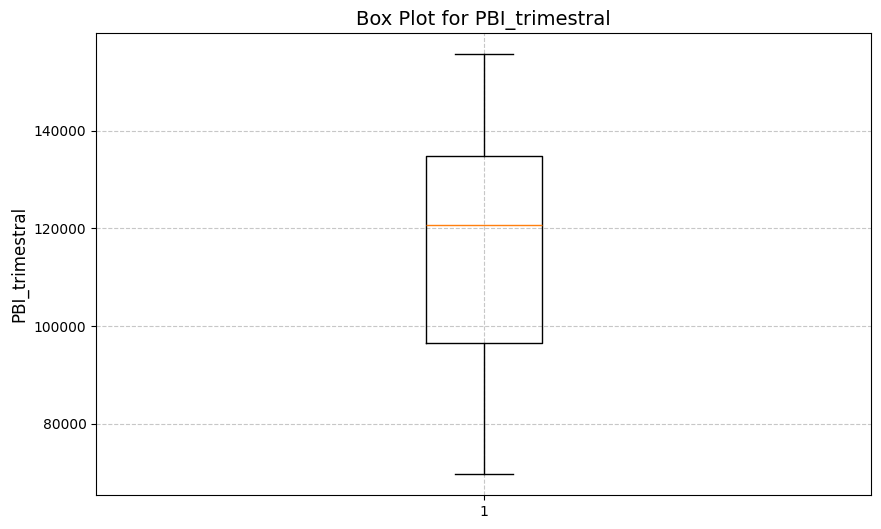

------------------------------------------------------------
Outliers usando Z-Score method:
Total: 1
------------------------------------------------------------
Outliers using IQR method:
Total: 0


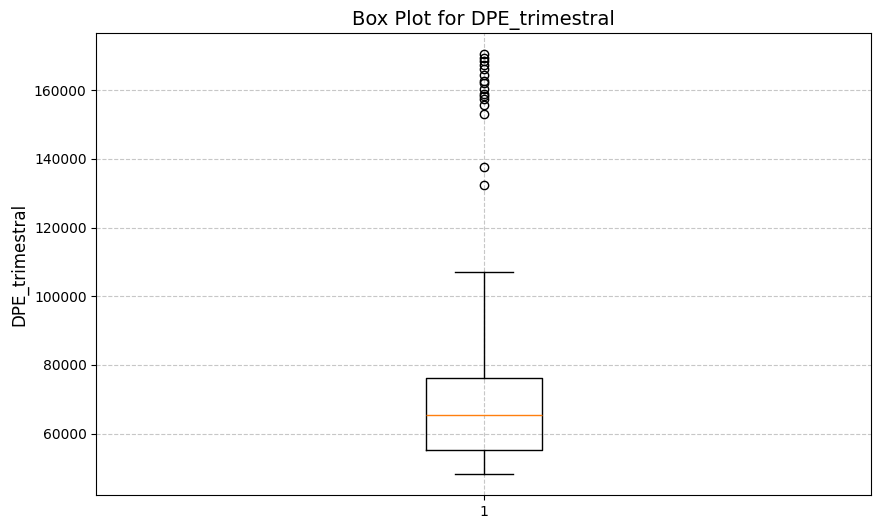

------------------------------------------------------------
Outliers usando Z-Score method:
Total: 5
------------------------------------------------------------
Outliers using IQR method:
Total: 16


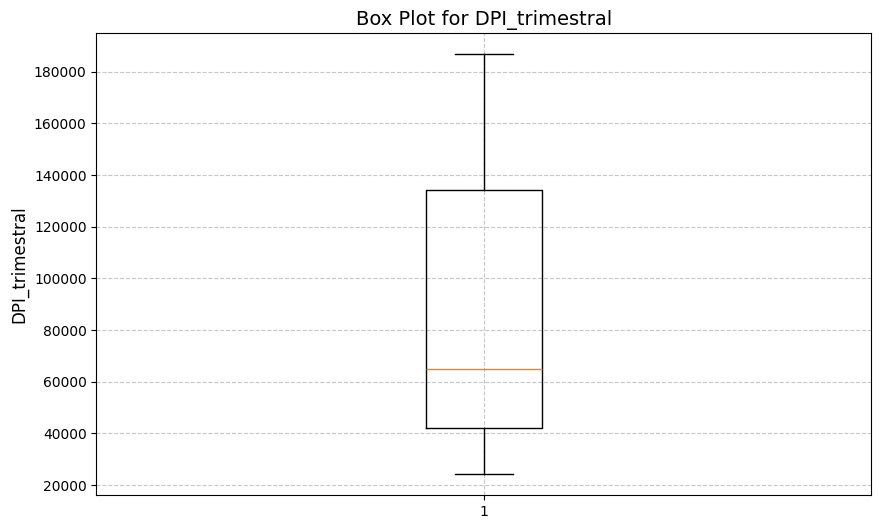

------------------------------------------------------------
Outliers usando Z-Score method:
Total: 1
------------------------------------------------------------
Outliers using IQR method:
Total: 0


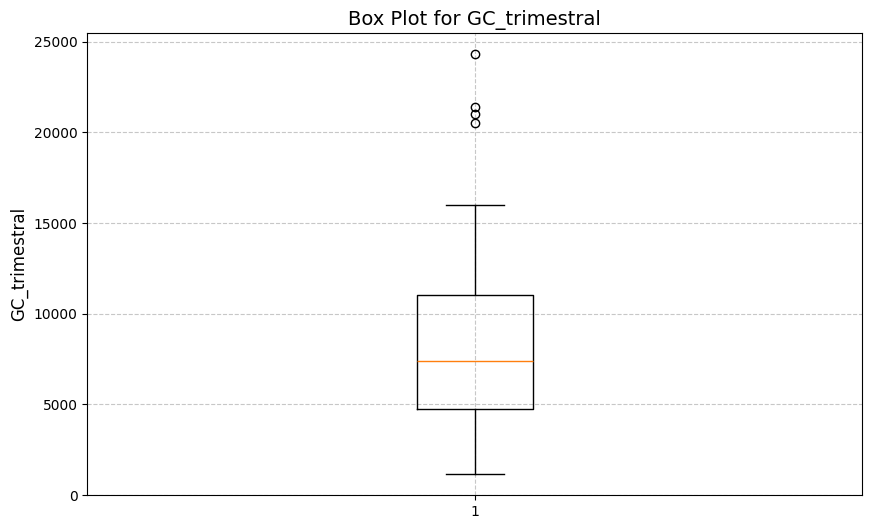

------------------------------------------------------------
Outliers usando Z-Score method:
Total: 4
------------------------------------------------------------
Outliers using IQR method:
Total: 4


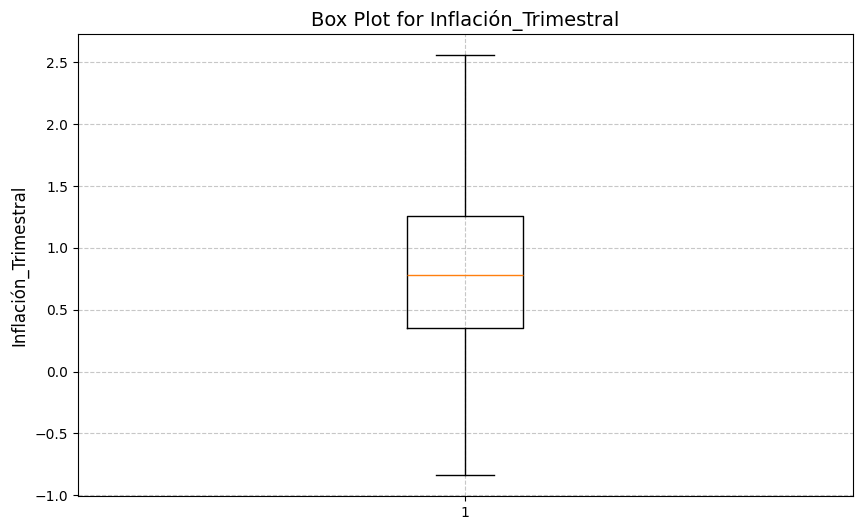

------------------------------------------------------------
Outliers usando Z-Score method:
Total: 3
------------------------------------------------------------
Outliers using IQR method:
Total: 0


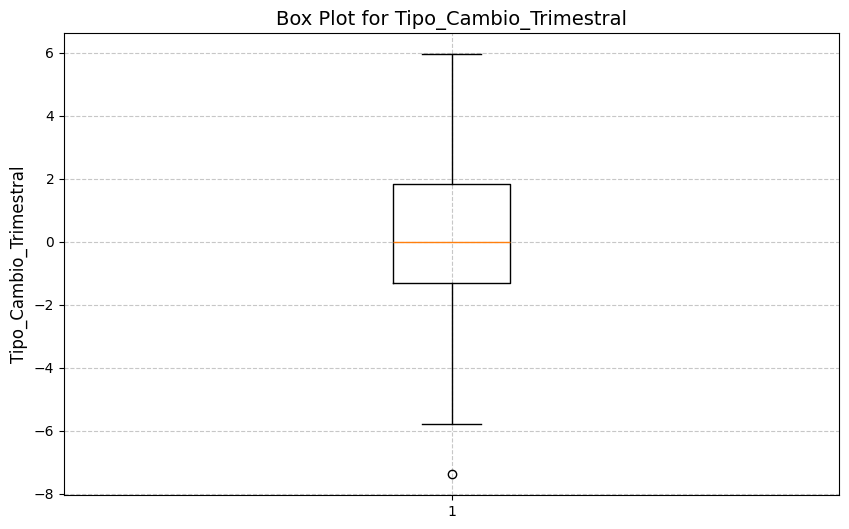

------------------------------------------------------------
Outliers usando Z-Score method:
Total: 5
------------------------------------------------------------
Outliers using IQR method:
Total: 1
¬øQu√© tipo de metodolog√≠a prefieres usar?
a. Z-Score.
b. Capping/ Flooring Outliers (IQR).
c. Log Transformaci√≥n.
Seleccione opci√≥n: B
Outliers limitados por el m√©todo IQR con √©xito.
¬øQu√© tipo de metodolog√≠a prefieres usar?
a. Z-Score.
b. Capping/ Flooring Outliers (IQR).
c. Log Transformaci√≥n.
Seleccione opci√≥n: B
Outliers limitados por el m√©todo IQR con √©xito.
¬øQu√© tipo de metodolog√≠a prefieres usar?
a. Z-Score.
b. Capping/ Flooring Outliers (IQR).
c. Log Transformaci√≥n.
Seleccione opci√≥n: B
Outliers limitados por el m√©todo IQR con √©xito.


In [4]:
#%% PREPROCESAMIENTO DE DATOS
def missing_values(df: pd.DataFrame):
    """
    Reporte General sobre la situaci√≥n de los datos descargados.
    """
    # Cantidad de datos faltantes.
    df = df
    missing_data = df.isnull().sum()

    return print(f"Cantidad de datos faltantes:\n {missing_data}")

# Revisar si hay datos faltantes
missing_values(y) # No los hay
missing_values(x) # No los hay

# OUTLIERS
def outliers(df: pd.DataFrame, column: str='Close'):
    # Por observar: CON RETORNOS (ESTACIONARIOS PRIMERO)
    # Identificar valores at√≠picos (Close)
    # 1. Box Plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Crear boxplot
    ax.boxplot(df[column].dropna(), vert=True)  # `vert=True` para orientaci√≥n vertical

    # Personalizar t√≠tulo y etiquetas
    ax.set_title(f'Box Plot for {column}', fontsize=14)
    ax.set_ylabel(column, fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)

    # Mostrar el gr√°fico
    plt.show()

    # 2. Z-Score
    # La puntuaci√≥n z indica a cu√°ntas desviaciones est√°ndar se encuentra un elemento
    # de la media. Normalmente, una puntuaci√≥n z mayor que dos o menor que -2,
    # a veces mayor que tres o menor que -3, se considera un valor at√≠pico.
    # Calcular el z-score
    df['Z_score'] = (df[column] - df[column].mean()) / df[column].std()

    # Identificar el Outliers
    outliers_z_score = df[np.abs(df['Z_score']) > 2]
    print("---" * 20)
    print("Outliers usando Z-Score method:")
    print(f"Total: {len(outliers_z_score)}")

    # 3. Interquartile Range (IQR)
    # El RIQ oscila entre el primer cuartil (percentil 25) y el
    # tercer cuartil (percentil 75). Los valores at√≠picos suelen definirse como
    # puntos de datos que se encuentran m√°s all√° de 1,5 veces el RIQ por encima
    # del tercer cuartil o por debajo del primer cuartil.
    # Calcular el IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Identificar el Outlier
    outliers_iqr = df[(df[column] < (Q1 - 1.5 * IQR)) |
    (df[column] > (Q3 + 1.5 * IQR))]

    print("---" * 20)
    print("Outliers using IQR method:")
    print(f"Total: {len(outliers_iqr)}")

    return outliers_z_score, outliers_iqr

# Verificar si existen datos at√≠picos en las series
# Variable Dependiente
z_score, iqr = outliers(y, column="PBI_trimestral") # 1, 0
# Variable Independiente
z_score, iqr = outliers(x, column="DPE_trimestral") # 5, 16 -> Exceso de outliers por COVID / Log
z_score, iqr = outliers(x, column="DPI_trimestral") # 1, 0 -> Log para que vaya a la par con el DPE
z_score, iqr = outliers(x, column="GC_trimestral") # 4, 4 -> Exceso de outliers continuos / Log
z_score, iqr = outliers(x, column="Inflaci√≥n_Trimestral") # 3, 0
z_score, iqr = outliers(x, column="Tipo_Cambio_Trimestral") # 5, 1 -> IQR

# Conclusi√≥n:
# - Necesario el tratamiento de outliers.
# - Metodolog√≠a a utilizar: Log

def outliers_management(df: pd.DataFrame, column: str='Close'):

    # Tipos de Manjeos de Outliers
    print("¬øQu√© tipo de metodolog√≠a prefieres usar?")
    print("a. Z-Score.")
    print("b. Capping/ Flooring Outliers (IQR).")
    print("c. Log Transformaci√≥n.")
    opciones = input("Seleccione opci√≥n: ").lower()

    # Tratar Outliers
    if opciones == 'a':
        # Calculate Z-scores
        df['Z_score'] = (df[column] - df[column].mean()) / df[column].std()

        # Eliminar outliers usando z-score m√©todo
        df = df[np.abs(df['Z_score']) <= 2]
        df = df.drop(columns=['Z_score'])
        print("Outliers eliminados por el m√©todo Z-Score con √©xito.")
        return df

    elif opciones == 'b':
        # L√≠mites m√≠nimos los cuales se reducidas su influencia como outliers.
        # Calcular IQR
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        # Limitaci√≥n de Outliers usando IQR m√©todo
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[column] = np.where(df[column] > upper_bound, upper_bound,
                                      np.where(df[column] < lower_bound, lower_bound, df[column]))

        print("Outliers limitados por el m√©todo IQR con √©xito.")

        return df

    elif opciones == 'c':
        # Log transformation to reduce the impact of outliers
        df[f'log_{column}'] = np.log(df[column])
        print("Outliers transformados por el m√©todo Log con √©xito.")

        return df

    else:
        RuntimeError("Introducir alternativa v√°lida.")

y = y.drop(["Z_score"], axis=1)
x = x.drop(["Z_score"], axis=1)

# Para PBI
y["PBI_trimestral_IQR"] = outliers_management(y, column="PBI_trimestral")

# Para X
x["log_DPE_trimestral"] = np.log(x["DPE_trimestral"])
x["log_DPI_trimestral"] = np.log(x["DPI_trimestral"])
x["log_GC_trimestral"] = np.log(x["GC_trimestral"])
x["Inflaci√≥n_Trimestral_IQR"] = outliers_management(x[["Inflaci√≥n_Trimestral"]], column="Inflaci√≥n_Trimestral")
x["Tipo_Cambio_Trimestral_IQR"] = outliers_management(x[["Tipo_Cambio_Trimestral"]], column="Tipo_Cambio_Trimestral")

# Drop columns
x = x.drop(x.columns[:5], axis=1)
y = y.iloc[:, [1]]

KPSS Statistic: 0.3231591205024562
p-value: 0.01
Number of lags used: 3
Critical Values:
  10% : 0.119
  5% : 0.146
  2.5% : 0.176
  1% : 0.216

üìå Interpretaci√≥n:
Conclusi√≥n: La serie NO es estacionaria (se rechaza H‚ÇÄ).
‚Üí No es estacionaria en nivel con tendencia.
KPSS Statistic: 0.2957395349731185
p-value: 0.01
Number of lags used: 5
Critical Values:
  10% : 0.119
  5% : 0.146
  2.5% : 0.176
  1% : 0.216

üìå Interpretaci√≥n:
Conclusi√≥n: La serie NO es estacionaria (se rechaza H‚ÇÄ).
‚Üí No es estacionaria en nivel con tendencia.
KPSS Statistic: 0.12736388856695777
p-value: 0.08451131746859672
Number of lags used: 5
Critical Values:
  10% : 0.119
  5% : 0.146
  2.5% : 0.176
  1% : 0.216

üìå Interpretaci√≥n:
Conclusi√≥n: La serie ES estacionaria (no se rechaza H‚ÇÄ).
‚Üí Estacionaria en nivel con tendencia.
KPSS Statistic: 0.25109237907919685
p-value: 0.01
Number of lags used: 1
Critical Values:
  10% : 0.119
  5% : 0.146
  2.5% : 0.176
  1% : 0.216

üìå Interpretaci√≥n:


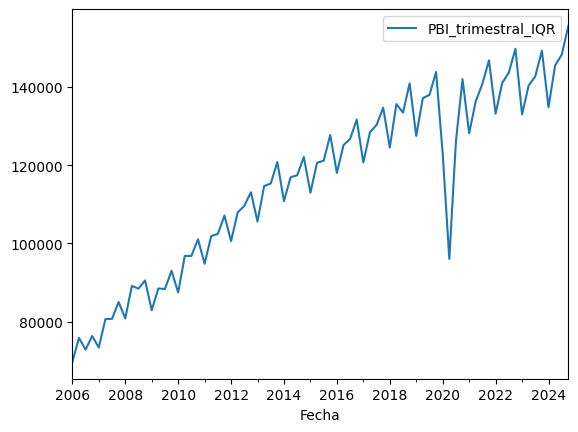

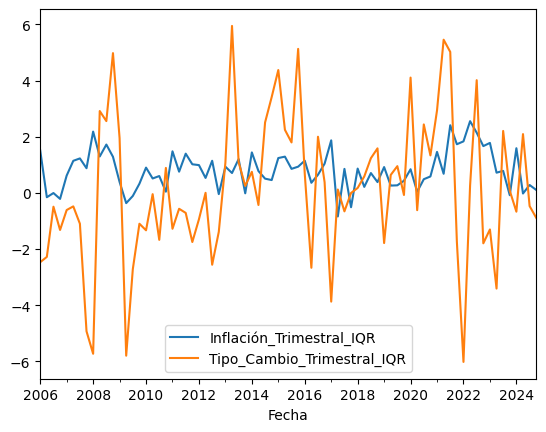

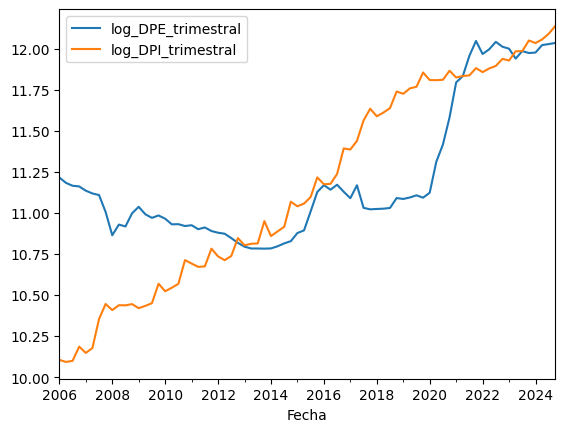

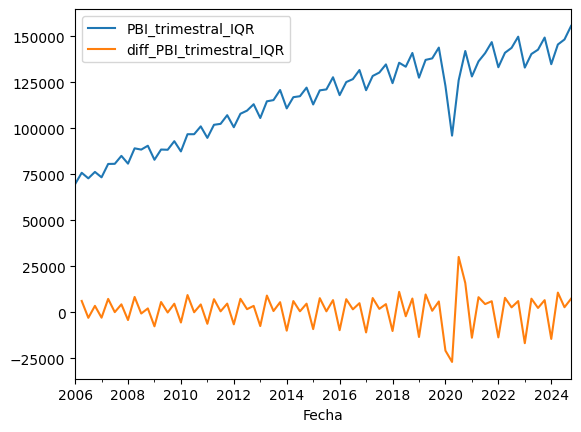

In [5]:
#%% INGENIERIA DE DATOS
# A. Estacionarizaci√≥n
def adf_test(df: pd.DataFrame, column: str = 'Close', regression: str = 'ct'):
    """
    Realiza la prueba de Dickey-Fuller aumentada (ADF) sobre una columna de un DataFrame.

    Par√°metros:
      - df: pd.DataFrame con los datos de series temporales.
      - column: str, el nombre de la columna a evaluar.
      - regression: str, tipo de regresi√≥n ('c', 'ct', 'n').
    """
    if column not in df.columns:
        raise ValueError(f"La columna '{column}' no est√° en el DataFrame.")

    series = df[column].dropna()
    result = adfuller(series, regression=regression, autolag='AIC')

    print("üìå Hip√≥tesis del test ADF:")
    print("  H‚ÇÄ: La serie tiene una ra√≠z unitaria (NO estacionaria).")
    print("  H‚ÇÅ: La serie es estacionaria.\n")

    print(f'ADF Statistic for {column}: {result[0]}')
    print(f'p-value for {column}: {result[1]}')
    print(f'# Lags used: {result[2]}')
    print(f'# Observations: {result[3]}\n')

    # Evaluaci√≥n
    if result[1] <= 0.05:
        print(f"‚úÖ Conclusi√≥n: La serie '{column}' es ESTACIONARIA (rechazamos H‚ÇÄ, p ‚â§ 0.05).")
    else:
        print(f"‚ö†Ô∏è Conclusi√≥n: La serie '{column}' NO es estacionaria (no se rechaza H‚ÇÄ, p > 0.05).")

    print("\nüìä Valores cr√≠ticos:")
    for key, value in result[4].items():
        nivel = "Estacionaria" if result[0] < value else "No estacionaria"
        print(f"  {key}%: {value:.3f} ‚Üí {nivel} a este nivel")

    return None #result  # opcional, si deseas usar los valores luego

def run_kpss_test(series, regression='ct', nlags='auto'):
    """
    Ejecuta la prueba KPSS en la serie indicada.

    Par√°metros:
      - series: La serie temporal (pandas.Series) a testear.
      - regression: Tipo de regresi√≥n ('c' para constante, 'ct' para constante y tendencia).
      - nlags: N√∫mero de lags a utilizar (puede ser 'auto').

    Imprime:
      - KPSS Statistic, p-value, valores cr√≠ticos y una conclusi√≥n sobre la estacionariedad.
    """
    from statsmodels.tsa.stattools import kpss

    statistic, p_value, n_lags, critical_values = kpss(series, regression=regression, nlags=nlags)

    print("KPSS Statistic:", statistic)
    print("p-value:", p_value)
    print("Number of lags used:", n_lags)
    print("Critical Values:")
    for key, value in critical_values.items():
        print(f"  {key} : {value}")

    # Interpretaci√≥n
    print("\nüìå Interpretaci√≥n:")
    if p_value < 0.05:
        print("Conclusi√≥n: La serie NO es estacionaria (se rechaza H‚ÇÄ).")
        if regression == 'ct':
            print("‚Üí No es estacionaria en nivel con tendencia.")
        else:
            print("‚Üí No es estacionaria en nivel.")
    else:
        print("Conclusi√≥n: La serie ES estacionaria (no se rechaza H‚ÇÄ).")
        if regression == 'ct':
            print("‚Üí Estacionaria en nivel con tendencia.")
        else:
            print("‚Üí Estacionaria en nivel (sin tendencia).")

run_kpss_test(y) # No estacionaria
run_kpss_test(x[["log_DPE_trimestral"]]) # No estacionaria
run_kpss_test(x[["log_DPI_trimestral"]]) # Estacionaria
run_kpss_test(x[["log_GC_trimestral"]]) # No estacionaria
run_kpss_test(x[["Inflaci√≥n_Trimestral_IQR"]]) # Es Estacionaria
run_kpss_test(x[["Tipo_Cambio_Trimestral_IQR"]]) # Es Estacionaria.

adf_test(y, column="PBI_trimestral_IQR") # No estacionaria
adf_test(x, column="log_DPE_trimestral") # No es estacionaria
adf_test(x, column="log_DPI_trimestral") # Es estacionaria solo a 10%
adf_test(x, column="log_GC_trimestral") # No es estacionaria
adf_test(x, column="Inflaci√≥n_Trimestral_IQR") # No es estacionaria a 1%
adf_test(x, column="Tipo_Cambio_Trimestral_IQR") # Es Estacionaria

y.plot()
x[["Inflaci√≥n_Trimestral_IQR","Tipo_Cambio_Trimestral_IQR"]].plot()
x[["log_DPE_trimestral","log_DPI_trimestral"]].plot()

# Aplicar la Diferenciaci√≥n Fraccionaria -> PBI_trimestral_IQR, log_DPE_trimestral, DPI_trimestral_IQR, log_GC_trimestral

# 1. PBI_trimestral_IQR
y["diff_PBI_trimestral_IQR"] = y["PBI_trimestral_IQR"].diff()
y.plot()
adf_test(y, column="diff_PBI_trimestral_IQR", regression="c") # Es Estacionaria
run_kpss_test(y["diff_PBI_trimestral_IQR"].iloc[1:], regression="c") # Es Estacionario

# 2. log_DPE_trimestral
x["diff_log_DPE_trimestral"] = x["log_DPE_trimestral"].diff()
adf_test(x[["diff_log_DPE_trimestral"]], column="diff_log_DPE_trimestral") # Es Estacionaria (mayor 5%)
run_kpss_test(x["diff_log_DPE_trimestral"].iloc[1:], regression="c") # Es Estacionaria

# 3. diff_log_DPI_trimestral
x["diff_log_DPI_trimestral"] = x["log_DPI_trimestral"].diff()
adf_test(x[["diff_log_DPI_trimestral"]], column="diff_log_DPI_trimestral") # No es Estacionaria
run_kpss_test(x["diff_log_DPI_trimestral"].iloc[1:], regression="c", nlags="auto") # Es Estacionaria

# 4. log_GC_trimestral
x["diff_2_log_GC_trimestral"] = x["log_GC_trimestral"].diff().diff()
adf_test(x[["diff_2_log_GC_trimestral"]], column="diff_2_log_GC_trimestral", regression="c") # Es Estacionaria
run_kpss_test(x["diff_2_log_GC_trimestral"].iloc[2:], regression="c", nlags="auto") # Es Estacionaria

# Quedarnos con los valores que coincidan con el √≠ndice de y.
x = x.drop(x.columns[:3], axis=1)
x = x.dropna()
y = y["diff_PBI_trimestral_IQR"].dropna()
y = y.loc[y.index.intersection(x.index)]

# B. SPLIT DE DATOS
split = 0.2
x_train, x_test = train_test_split(x ,test_size=split, shuffle=False)
y_train, y_test = train_test_split(y ,test_size=split, shuffle=False)

y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

# C. NORMALIZACION
# Normalizaci√≥n -> Para hacerlos escalable (no asumen una distribuci√≥n de los datos)
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

# Entrenar la Data Transformada
x_train_scaler = scaler_X.fit_transform(x_train)
x_test_scaler = scaler_X.transform(x_test)

y_train_scaler = scaler_Y.fit_transform(y_train)


Fitting 5 folds for each of 1440 candidates, totalling 7200 fits

GridSearch completado en 190.1s
Mejores par√°metros: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 150, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 1.0}

Train ‚Üí MSE: 1799569.8750, MAE: 925.5894, R¬≤: 0.9770
Test  ‚Üí MSE: 18728410.0000, MAE: 3470.3259, R¬≤: 0.7529
Correlaci√≥n Train: 0.9912
Correlaci√≥n Test : 0.9178


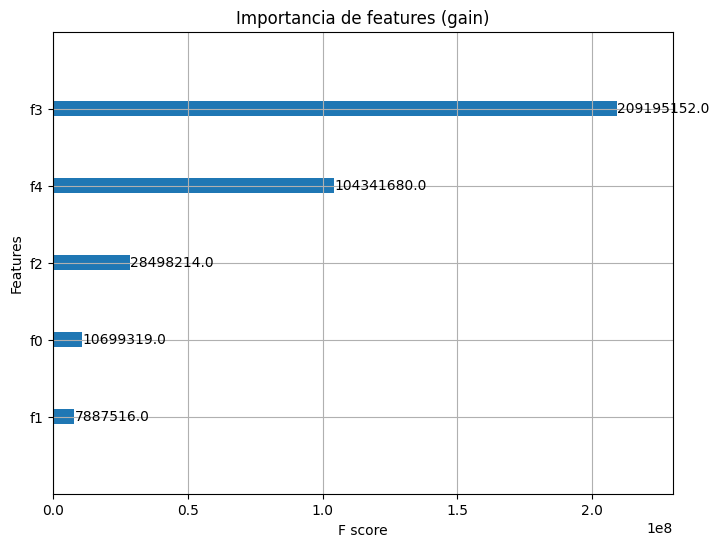

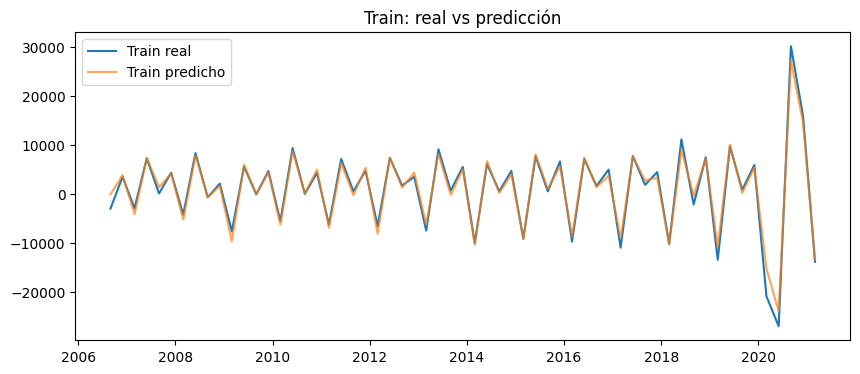

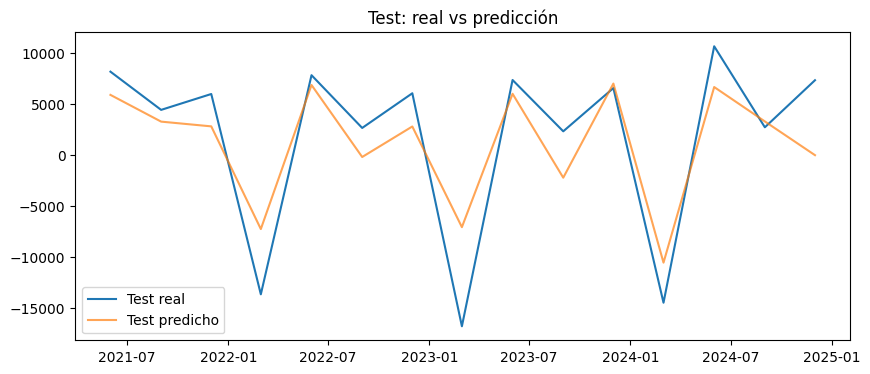

In [6]:
#%% MODELO - XGBoost
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1) Split temporal
tscv = TimeSeriesSplit(n_splits=5)

# 2) Grid reducido para evitar b√∫squedas excesivas
param_grid_small = {
    'n_estimators':     [30, 50, 70, 100, 150],
    'learning_rate':    [0.01, 0.05],
    'max_depth':        [3, 6],
    'gamma':            [0, 0.1],
    'subsample':        [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha':        [0, 0.01, 0.1],  # L1 regularizaci√≥n
    'reg_lambda':       [1, 5, 10]      # L2 regularizaci√≥n
}

# 3) Modelo base
base_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=1,
    verbosity=0,
    n_jobs=-1
)

# 4) GridSearchCV con TimeSeriesSplit (sin early stopping dentro)
grid = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid_small,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2,
    error_score='raise'
)

# 5) B√∫squeda de hiperpar√°metros (solo entrenamiento)
start = time.time()
grid.fit(x_train_scaler, y_train)
print(f"\nGridSearch completado en {time.time() - start:.1f}s")
print('Mejores par√°metros:', grid.best_params_)

# 6) Modelo final con early stopping configurado en el constructor
best_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=1,
    verbosity=0,
    n_jobs=-1,
    **grid.best_params_,
    eval_metric='rmse',            # m√©trica de validaci√≥n
    early_stopping_rounds=20       # parar√° si no mejora en validaci√≥n interna
)

# Definir validaci√≥n para early stopping (parte de test o split adicional)
eval_set = [(x_test_scaler, y_test)]

# 7) Entrenamiento final
best_model.fit(
    x_train_scaler, y_train,
    eval_set=eval_set,
    verbose=False
)

# 8) Predicciones
y_train_pred = best_model.predict(x_train_scaler)
y_test_pred  = best_model.predict(x_test_scaler)

# 9) M√©tricas de error
mse_tr = mean_squared_error(y_train, y_train_pred)
mae_tr = mean_absolute_error(y_train, y_train_pred)
r2_tr  = r2_score(y_train, y_train_pred)

mse_te = mean_squared_error(y_test, y_test_pred)
mae_te = mean_absolute_error(y_test, y_test_pred)
r2_te  = r2_score(y_test, y_test_pred)

print(f"\nTrain ‚Üí MSE: {mse_tr:.4f}, MAE: {mae_tr:.4f}, R¬≤: {r2_tr:.4f}")
print(f"Test  ‚Üí MSE: {mse_te:.4f}, MAE: {mae_te:.4f}, R¬≤: {r2_te:.4f}")

# 10) Correlaci√≥n real vs predicha
# Aplanar vectores y crear Series alineadas
train_true = pd.Series(np.ravel(y_train), index=y_train.index)
train_pred = pd.Series(y_train_pred.ravel() if hasattr(y_train_pred, 'ravel') else y_train_pred, index=y_train.index)

test_true = pd.Series(np.ravel(y_test), index=y_test.index)
test_pred = pd.Series(y_test_pred.ravel()  if hasattr(y_test_pred,  'ravel') else y_test_pred,  index=y_test.index)

corr_tr = train_true.corr(train_pred)
corr_te = test_true.corr(test_pred)
print(f"Correlaci√≥n Train: {corr_tr:.4f}")
print(f"Correlaci√≥n Test : {corr_te:.4f}")

# 11) Importancia de features (gain)
fig, ax = plt.subplots(figsize=(8, 6))
xgb.plot_importance(best_model, importance_type='gain', ax=ax)
ax.set_title('Importancia de features (gain)')
plt.show()

# 12) Gr√°ficos de ajuste
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(y_train.index, y_train, label='Train real')
ax.plot(y_train.index, y_train_pred, label='Train predicho', alpha=0.7)
ax.legend(); ax.set_title('Train: real vs predicci√≥n')
plt.show()

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(y_test.index, y_test, label='Test real')
ax.plot(y_test.index, y_test_pred, label='Test predicho', alpha=0.7)
ax.legend(); ax.set_title('Test: real vs predicci√≥n')
plt.show()

Model: "sequential"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ simple_rnn (SimpleRNN)          ‚îÇ (None, 80)             ‚îÇ         6,880 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout (Dropout)               ‚îÇ (None, 80)             ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense (Dense)                   ‚îÇ (None, 50)             ‚îÇ         4,050 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_1 (Dropout)             ‚îÇ (None, 50)             ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_1 (Dense)                 ‚îÇ (None, 20)             ‚îÇ         1,020 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_2 (Dropout)             ‚îÇ (None, 20)             ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_2 (Dense)                 ‚îÇ (None, 1)              ‚îÇ            21 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 11,971 (46.76 KB)

 Trainable params: 11,971 (46.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
15/15 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 30ms/step - loss: 64556232.0000 - sign_accuracy: 0.3632 - val_loss: 79155344.0000 - val_sign_accuracy: 0.9375
Epoch 2/500
15/15 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 7ms/step - loss: 63005940.0000 - sign_accuracy: 0.5728 - val_loss: 79153784.0000 - val_sign_accuracy: 0.8750
Epoch 3/500
15/15 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 7ms/step - loss: 71024232.0000 - sign_accuracy: 0.8218 - val_loss: 79151768.0000 - val_sign_accuracy: 0.8750
Epoch 4/500
15/15 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 7ms/step - loss: 117846800.0000 - sign_accuracy: 0.7826 - val_loss: 79150032.0000 - val_sign_accuracy: 0.9375
Epoch 5/500
15/15 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 7ms/step - loss: 92772960.0000 - sign_accuracy: 0.7406 - val_loss: 79147432.0000 - val_sign_accuracy: 0.9375
Epoch 6/500
15/15 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚

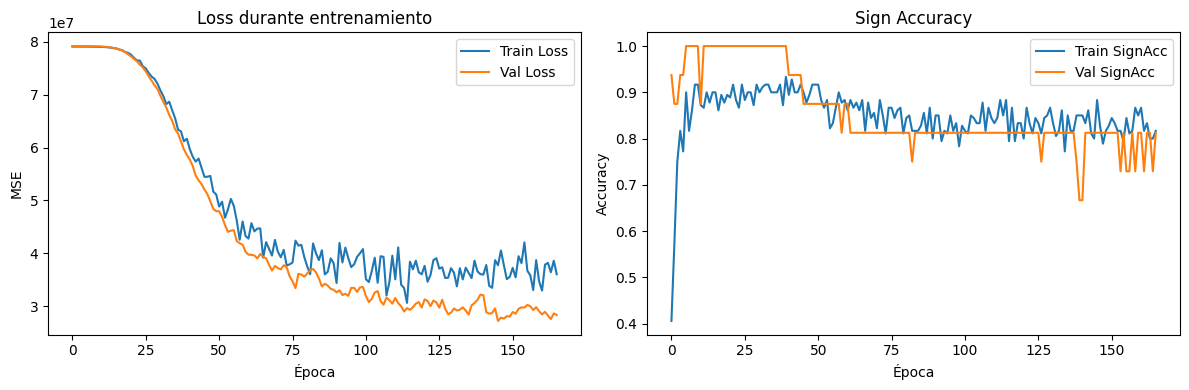

2/2 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 182ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 45ms/step
Sign Accuracy Train: 81.67%
Sign Accuracy Val  : 81.25%
RMSE Train: 5840.263995505728
RMSE Test : 5220.021919016701
R2 Train : 0.5642438590909625
R2 Test  : 0.6405352976398309


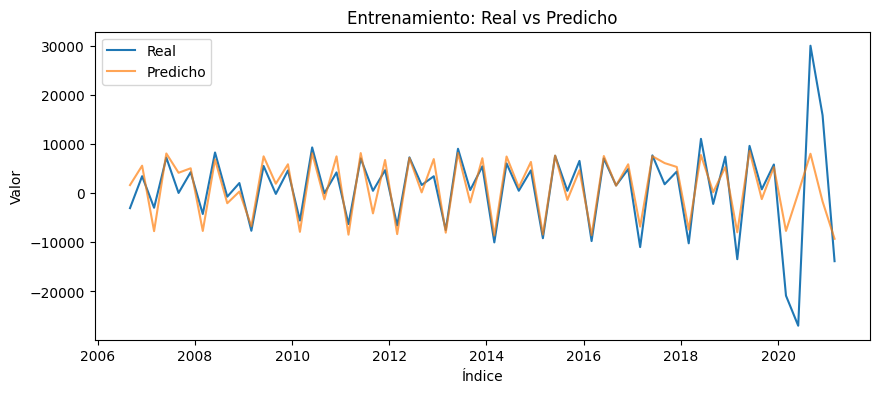

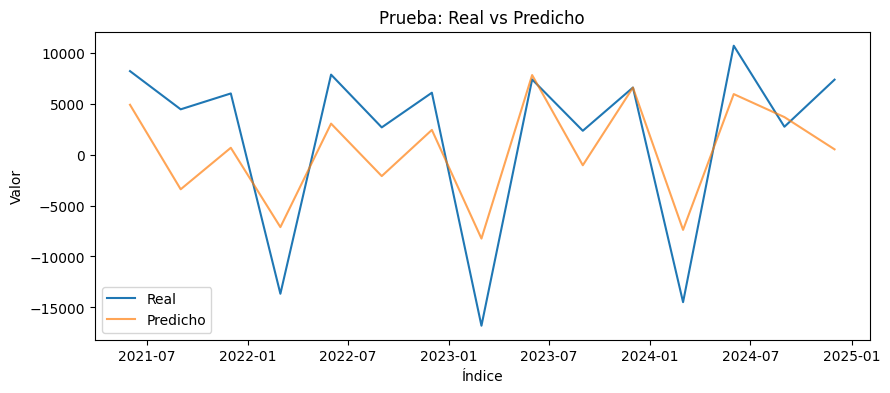

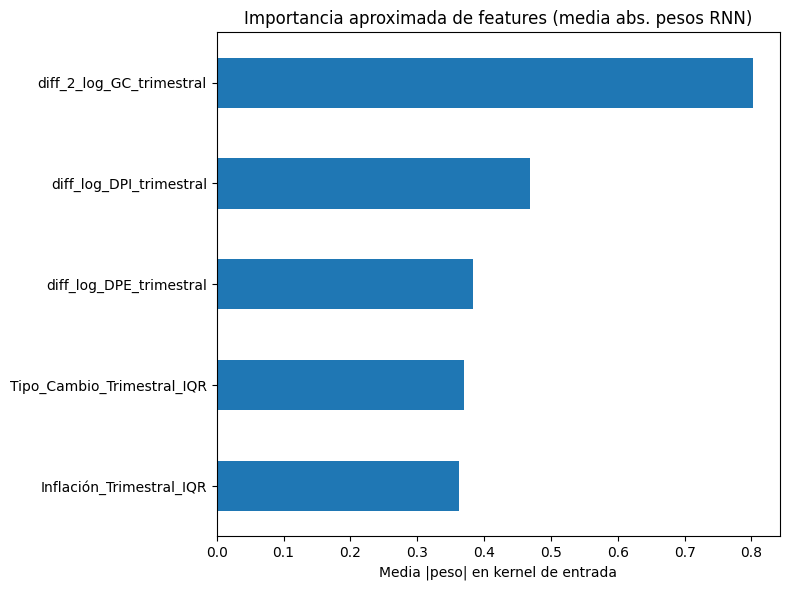

In [7]:
#%% MODELO - RED NEURONAL
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from sklearn.metrics import mean_squared_error, r2_score

# M√©trica custom para precisi√≥n de signo
def sign_accuracy(y_true, y_pred):
    return K.mean(K.equal(K.sign(y_true), K.sign(y_pred)))

# Preparamos datos
y_train_arr = y_train.values.reshape(-1, 1)
y_test_arr  = y_test.values.reshape(-1, 1)
x_train_rnn = x_train_scaler.reshape((x_train_scaler.shape[0], 1, x_train_scaler.shape[1]))
x_test_rnn  = x_test_scaler.reshape((x_test_scaler.shape[0], 1, x_test_scaler.shape[1]))

# Construcci√≥n del modelo RNN con regularizaci√≥n
tf_model = Sequential([
    SimpleRNN(units=80, input_shape=(1, x_train_rnn.shape[2]), activation='tanh', return_sequences=False),
    #BatchNormalization(),
    Dropout(0.2),

    Dense(50, activation='relu'),
    #BatchNormalization(),
    Dropout(0.2),

    Dense(20, activation='relu'),
    #BatchNormalization(),
    Dropout(0.2),

    Dense(1)
])

# Compilar modelo
tf_model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=[sign_accuracy]
)

tf_model.summary()

# Early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

# Entrenamiento con EarlyStopping
start = time.time()
history = tf_model.fit(
    x_train_rnn, y_train_arr,
    epochs=500,
    batch_size=4,
    validation_data=(x_test_rnn, y_test_arr),
    callbacks=[early_stop],
    verbose=1
)
print(f"Tiempo de entrenamiento: {time.time() - start:.1f}s")

# Visualizaci√≥n de p√©rdida y sign accuracy
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(history.history['loss'], label='Train Loss')
ax[0].plot(history.history['val_loss'], label='Val Loss')
ax[0].set_title('Loss durante entrenamiento')
ax[0].set_xlabel('√âpoca')
ax[0].set_ylabel('MSE')
ax[0].legend()

ax[1].plot(history.history['sign_accuracy'], label='Train SignAcc')
ax[1].plot(history.history['val_sign_accuracy'], label='Val SignAcc')
ax[1].set_title('Sign Accuracy')
ax[1].set_xlabel('√âpoca')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
plt.tight_layout()
plt.show()

# Predicciones
y_train_pred = tf_model.predict(x_train_rnn).flatten()
y_test_pred  = tf_model.predict(x_test_rnn).flatten()

# M√©tricas de evaluaci√≥n
# √öltimos valores de sign_accuracy (en escala 0‚Äì1)
train_sign_acc = history.history['sign_accuracy'][-1]
val_sign_acc   = history.history['val_sign_accuracy'][-1]

print(f"Sign Accuracy Train: {train_sign_acc * 100:.2f}%")
print(f"Sign Accuracy Val  : {val_sign_acc   * 100:.2f}%")
print('RMSE Train:', np.sqrt(mean_squared_error(y_train_arr, y_train_pred)))
print('RMSE Test :', np.sqrt(mean_squared_error(y_test_arr, y_test_pred)))
print('R2 Train :', r2_score(y_train_arr, y_train_pred))
print('R2 Test  :', r2_score(y_test_arr, y_test_pred))

# Gr√°ficos Real vs Predicci√≥n
def plot_actual_vs_pred(idx, true, pred, title):
    plt.figure(figsize=(10,4))
    plt.plot(idx, true.flatten(), label='Real')
    plt.plot(idx, pred,        label='Predicho', alpha=0.7)
    plt.title(title)
    plt.xlabel('√çndice')
    plt.ylabel('Valor')
    plt.legend()
    plt.show()

plot_actual_vs_pred(y_train.index, y_train_arr, y_train_pred, 'Entrenamiento: Real vs Predicho')
plot_actual_vs_pred(y_test.index,  y_test_arr,  y_test_pred,  'Prueba: Real vs Predicho')

# Extraer Caracter√≠sticas m√°s importantes
# Convertir a lista el nombre de caracter√≠sticas
feature_names = x_train.columns.tolist()

# Consultar y extraer los pesos de la capa SimpleRNN
kernel_weights, recurrent_weights, rnn_bias = tf_model.layers[0].get_weights()

# kernel_weights.shape == (n_features, units)
# Para cada feature, calculamos la media de valores absolutos a lo largo de las unidades
importances = np.mean(np.abs(kernel_weights), axis=1)

# Convertir a un Series y lo ordenamos de mayor a menor
imp_series = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Graficar
plt.figure(figsize=(8, 6))
imp_series.plot(kind='barh')
plt.title("Importancia aproximada de features (media abs. pesos RNN)")
plt.xlabel("Media |peso| en kernel de entrada")
plt.gca().invert_yaxis()  # para que la de mayor importancia quede arriba
plt.tight_layout()
plt.show()
